# Summary

This notebook allows to reproduce the financial time series case study presented in Section 6 of the paper _"Learning Block-sparse Partial Correlation Graphs"_.
In addition, we show the results obtained from the mere application of the _Naive_ estimator.

# Libraries

In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import string

from copy import deepcopy

from jax.numpy import array, expand_dims, hanning, ones
from jax.numpy.fft import rfft
from jax.numpy.linalg import norm
from matplotlib.patches import PathPatch
from matplotlib.path import Path

from scipy.signal import fftconvolve

from src.models.nonconvex import IA_method
from src.utils import partial_coherence, hpinv, load_obj
from src.metrics import blocks_skeleton

from jax.config import config 
config.update("jax_enable_x64", True)

# Matplotlib params

In [2]:
LEGEND_SIZE = 11
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.rcParams['text.usetex'] = True

# Load data

In [3]:
# Data source: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_17_ind_port.html

data_dir="data/"
rets_bef=load_obj("2.0_returns_2018_2019", data_dir)
rets_aft=load_obj("2.0_returns_2020_2021", data_dir)

In [4]:
display(rets_bef), display(rets_aft)

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2018-01-05,0.18,0.17,-0.06,0.42,0.99,0.99,0.35,1.25,0.14,0.26,0.65,0.72,1.05,-0.18,1.05,0.64,0.83
2018-01-08,0.08,0.44,0.52,0.85,0.18,0.08,-0.11,-0.07,1.06,0.50,0.79,0.72,0.53,0.81,0.60,-0.26,0.08
2018-01-09,0.24,-1.22,-0.42,-0.68,-0.16,-0.25,0.42,0.16,-1.31,0.02,-0.20,-0.04,0.68,-0.85,-0.08,0.67,0.18
2018-01-10,-0.82,0.70,-0.19,-0.23,-0.90,-0.28,0.01,-0.88,1.79,-0.53,-0.61,-0.81,0.17,-1.14,0.14,0.62,-0.03
2018-01-11,-0.30,1.96,2.08,0.75,0.96,1.57,0.23,1.75,2.14,1.29,1.11,1.82,1.69,0.00,1.41,0.67,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.04,0.88,0.02,0.04,0.51,-0.01,-0.05,0.43,0.01,-0.38,-0.05,0.28,-0.27,0.01,0.13,0.08,-0.01
2019-12-26,0.21,1.11,0.07,0.45,-0.26,0.21,0.06,-0.03,-0.06,0.22,0.18,0.11,0.15,0.17,1.78,0.50,0.58
2019-12-27,0.43,-0.58,-0.59,0.28,-0.20,-0.45,0.15,-0.18,-0.30,-0.21,-0.19,-0.22,-0.20,0.15,0.02,-0.11,-0.11


,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2020-01-02,-1.01,-0.22,0.92,0.57,-0.03,-0.92,-0.10,0.10,-1.00,0.59,1.63,1.30,1.68,-1.31,1.15,0.77,1.29
2020-01-03,-0.01,-1.40,-0.32,-0.36,-0.58,-1.70,-0.68,-0.37,-1.03,-0.32,-1.05,-0.58,0.03,0.20,-0.75,-0.96,-0.68
2020-01-06,0.07,0.22,0.83,0.07,0.71,-0.47,0.28,0.46,-0.63,-0.74,-0.24,-0.32,-0.16,0.21,0.71,-0.03,0.73
2020-01-07,-0.93,0.07,-0.16,-0.29,-1.29,-0.24,-0.30,-0.54,0.46,-0.42,0.58,0.27,0.37,-0.20,-0.09,-0.55,-0.23
2020-01-08,0.27,-0.57,-1.92,-0.06,0.09,0.00,0.56,1.13,-0.54,0.29,0.14,1.04,0.15,-0.26,-0.31,0.90,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.80,1.59,2.53,1.49,0.75,1.48,0.83,1.68,1.90,1.50,2.37,2.21,0.66,0.61,0.23,0.93,1.15
2021-12-28,0.63,-0.12,-0.27,-0.35,-0.21,0.53,-0.07,0.39,-0.82,0.53,-0.80,-0.29,0.45,0.80,0.47,0.00,-0.52
2021-12-29,0.25,0.03,-0.58,1.15,0.04,0.44,0.42,1.01,0.15,0.72,0.20,-0.03,0.04,0.43,-0.11,-0.11,0.02


(None, None)

# Load results?

In [5]:
# If True, results from saved files will be loaded.
# If False, everything will be computed from scratch. 
load_results = False

# Smoothed periodogram

In [6]:
# Demean
rets_bef-=rets_bef.mean()
rets_aft-=rets_aft.mean()

# Shapes and daily freq
T_aft,N = rets_aft.shape
T_bef,_= rets_bef.shape
fs=252

print(T_bef, T_aft)

500 505


In [7]:
# Functions to compute the smoothed periodogram
def raw_periodogram(ts,fq):

    multiply_=lambda x: 1./(2*jnp.pi)*(x.reshape(-1,1)@x.reshape(-1,1).conj().T)
    Y=rfft(ts, norm="ortho", axis=0)[:fq//2+1]
    periodogram=jax.vmap(multiply_, 0, 2)(Y)
    return periodogram

window_box=lambda x: ones(N,N,2*x+1)/(2*x+1)
window_hann=lambda x: ones((N,N,1))*expand_dims(hanning(2*x+1)/(hanning(2*x+1)).sum(), (0,1))
smoothing=lambda x,win: fftconvolve(x, win, mode='same', axes=-1)

In [8]:
p=jnp.floor(jnp.sqrt(min(T_bef, T_aft))).astype(jnp.int32).item()
win = window_hann(p)

rp_bef=raw_periodogram(rets_bef.values,fs)
rp_aft=raw_periodogram(rets_aft.values,fs)

if load_results:
    sp_bef=load_obj("2.0_sp_bef", data_dir)
    sp_aft=load_obj("2.0_sp_aft", data_dir)
else:
    sp_bef=smoothing(rp_bef, win)
    sp_aft=smoothing(rp_aft, win)

# Check Hermitianity
for k in range(sp_bef.shape[-1]):
    assert jnp.allclose(sp_bef[...,k],sp_bef[...,k].conj().T)
    assert jnp.allclose(sp_aft[...,k],sp_aft[...,k].conj().T)

# Apply the AI method

In [9]:
K=jnp.arange(4,32,4)
coeff=1.e-2
lmbd=5.e-3
tauF=1.e-2
tauP=1.e-2 
kind=0
kind1=0
c1=.3 
c2=.99 
c3=.99 
c4=.99 
max_iter=2000
step=50
tolp=5.e-4
told=5.e-4
tolp_abs=tolp 
tolp_rel=tolp 
told_abs=told 
told_rel=told
only_primal=False

if load_results:
    results_bef=load_obj("2.0_results_bef", data_dir)
    results_aft=load_obj("2.0_results_aft", data_dir)
    Rl2_ours_bef=load_obj("2.0_Rl2_ours_bef", data_dir)
    Rl2_ours_aft=load_obj("2.0_Rl2_ours_aft", data_dir)
else:
    print("########### First Period ###########")
    F_hat=deepcopy(sp_bef[...,::4]) #subsampling
    eta_=coeff*norm(F_hat)
    eta=eta_ 

    algo=IA_method(K=K ,F_hat=F_hat, P_init="identity")
    F,P,vF,vP,vU,vX,vV,alpha,beta,mu,phi = algo.initialization(check_init=True)
    results_bef=algo.solve_vmap(F,P,vF,vP,vU,vX,vV,alpha,beta,mu,phi, lmbd, tauF, tauP, eta, kind, kind1, c1, c2, c3, c4, tolp_abs=tolp_abs, tolp_rel=tolp_rel, told_abs=told_abs, told_rel=told_rel, only_primal=only_primal, max_iter=max_iter, step=step)
    R_ours_bef=array(partial_coherence(results_bef['P']))
    Rl2_ours_bef=blocks_skeleton(R_ours_bef,K)
    Rl2_ours_bef/=Rl2_ours_bef.max(axis=(0,1)).reshape((1,1,-1))

    print("########### Second Period ###########")
    F_hat=deepcopy(sp_aft[...,::4]) #subsampling
    eta_=coeff*norm(F_hat)
    eta=eta_ 

    algo=IA_method(K=K ,F_hat=F_hat, P_init="identity")
    F,P,vF,vP,vU,vX,vV,alpha,beta,mu,phi = algo.initialization(check_init=True)
    results_aft=algo.solve_vmap(F,P,vF,vP,vU,vX,vV,alpha,beta,mu,phi, lmbd, tauF, tauP, eta, kind, kind1, c1, c2, c3, c4, tolp_abs=tolp_abs, tolp_rel=tolp_rel, told_abs=told_abs, told_rel=told_rel, only_primal=only_primal, max_iter=max_iter, step=step)
    R_ours_aft=array(partial_coherence(results_aft['P']))
    Rl2_ours_aft=blocks_skeleton(R_ours_aft,K)
    Rl2_ours_aft/=Rl2_ours_aft.max(axis=(0,1)).reshape((1,1,-1))


########### First Period ###########


Iteration: 50.0
objective: 43.136474962235425
Residuals for primal feasibility: U 0.028; X 0.029; FFT(F) -0.0; V 0.01
Residual for dual feasibility: sp F 0.055vs0.049; sp P 0.07200000000000001vs0.048
Primal feasibility conditions: True, True, True, True
Dual feasibility conditions: False, False
SCA stepsize value: 0.2153453362919348
ADMM stepsize value: 0.5516554118778519



################# Optimisation successfully completed #################


Last iteration: 83.0
objective: 40.3225154511772
Residuals for primal feasibility: U 0.012; X 0.012; FFT(F) -0.0; V 0.005
Residual for dual feasibility: sp F 0.042vs0.049; sp P 0.048vs0.048
Primal feasibility conditions: True, True, True, True
Dual feasibility conditions: True, True
SCA stepsize value: 0.17324936696418833
ADMM stepsize value: 0.4828836371435217



########### Second Period ###########


Iteration: 50.0
objective: 40.85142746294966
Residuals for primal feasibility: U 0.15; X 0.17; FFT(F) 

In [10]:
#seaborn settings
sns.set_context('talk')
pal=sns.color_palette("ch:d=0,l=1", as_cmap=True)

#x-axis
K1=jnp.arange(4/64,32/64,4/64)
K1=jnp.append(jnp.insert(K1,0,0),0.5)

#alphabet for labels
alphabet = list(string.ascii_uppercase)

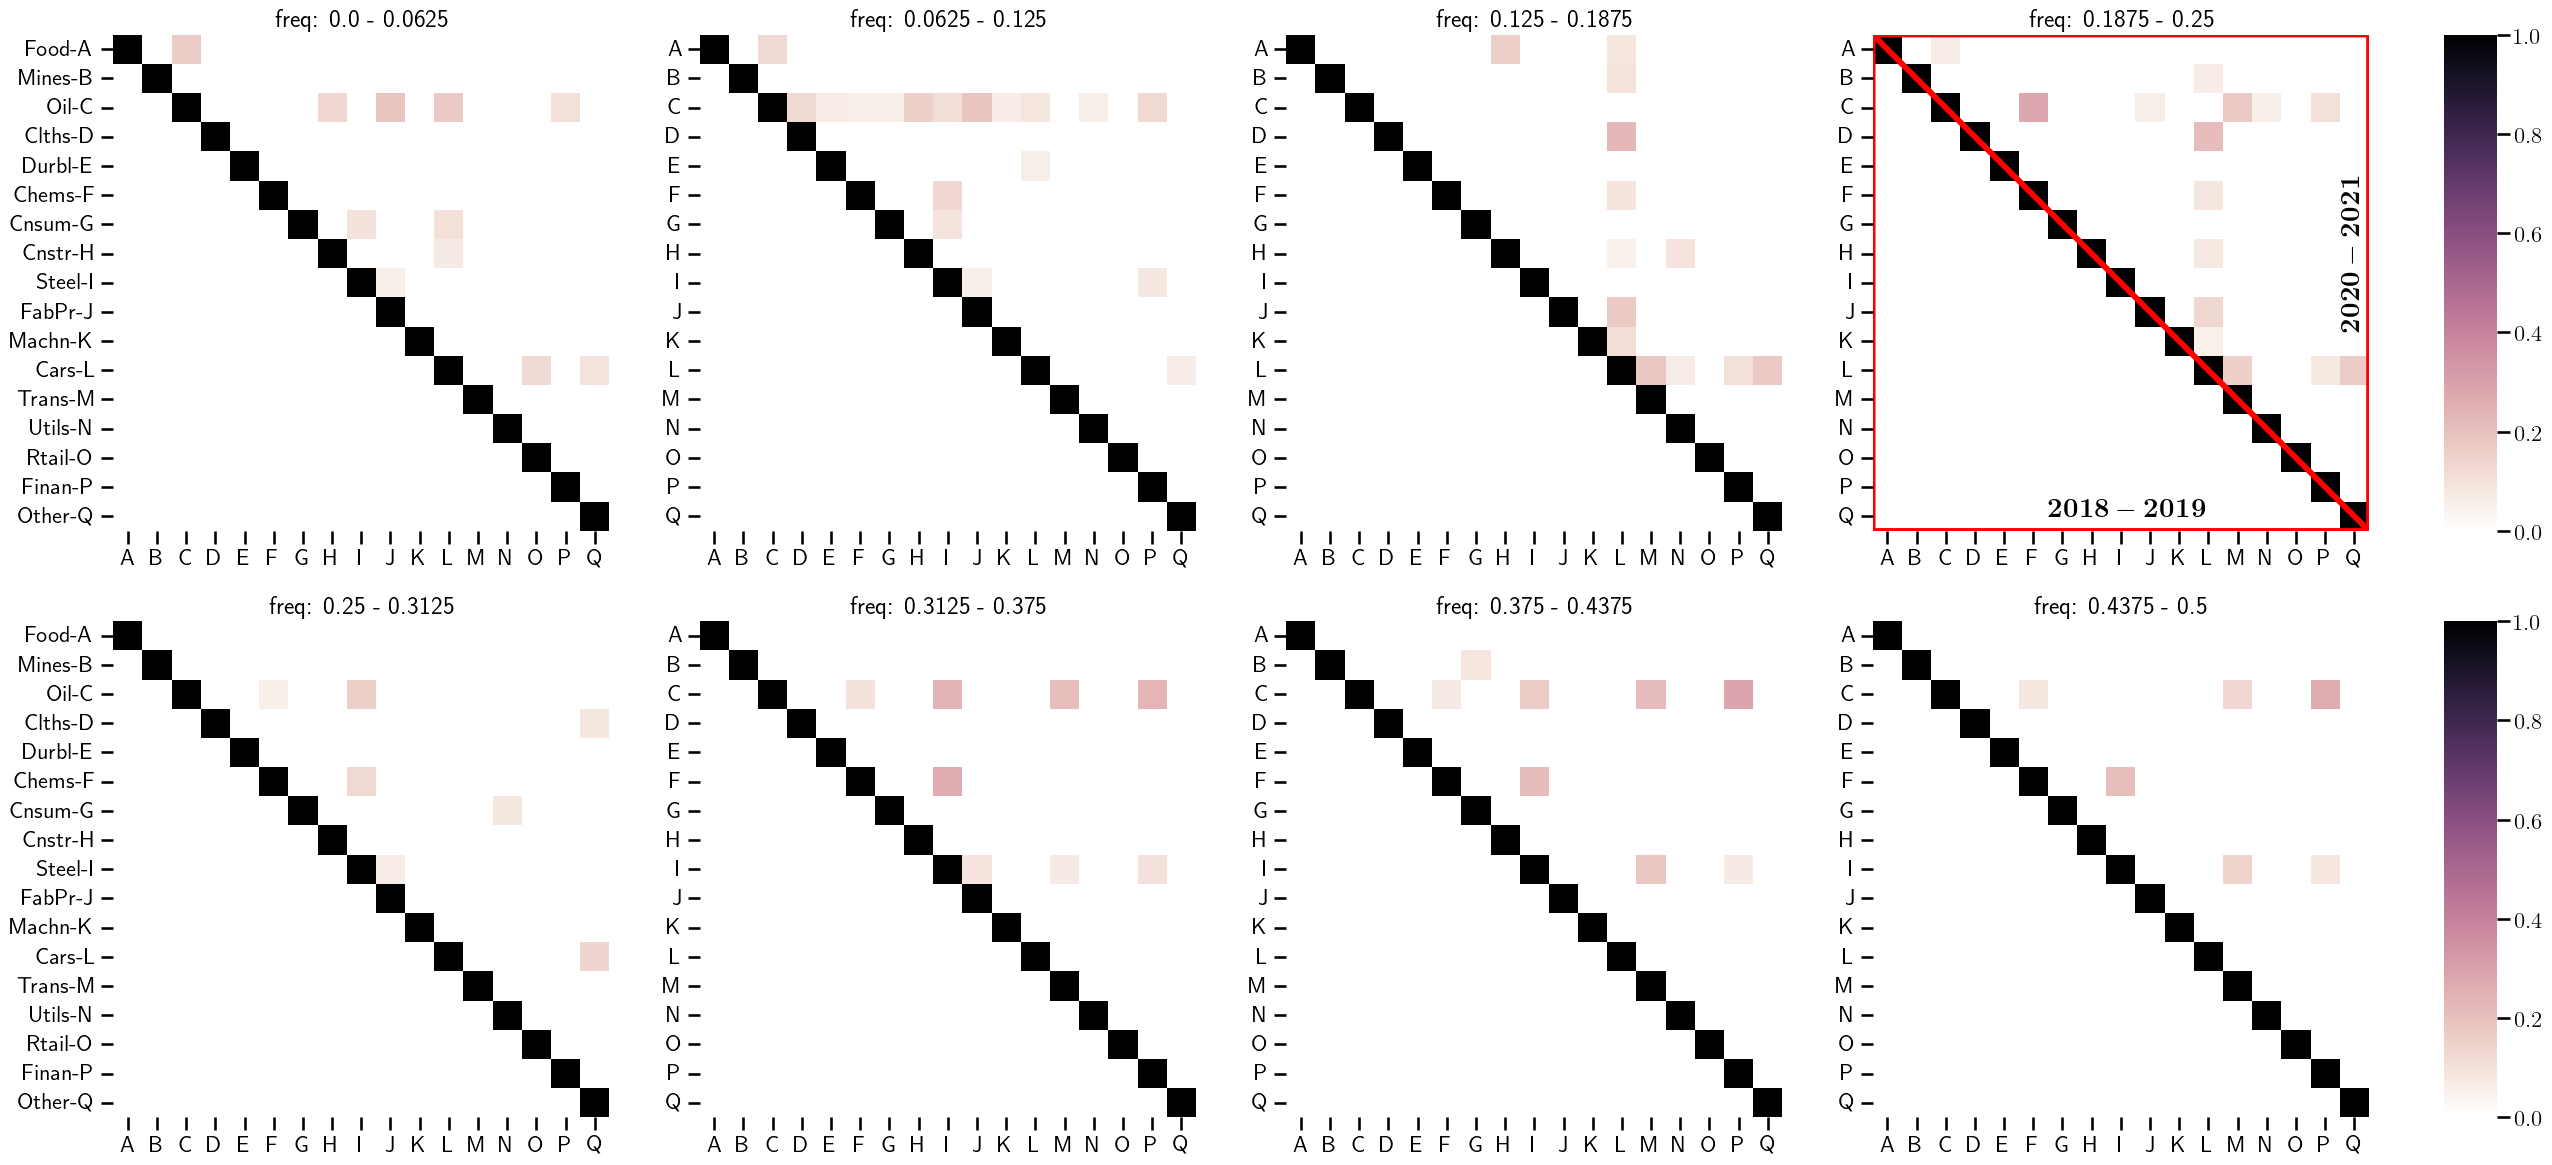

In [11]:
nrows=2
ncols=4
col_ = [rets_aft.columns[i].split(' ')[0]+'-'+alphabet[i] for i in range(len(rets_aft.columns))]
fig, ax = plt.subplots(nrows,ncols+1,figsize=(26,12), gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]}, sharex=False, sharey=False)

for k in range(Rl2_ours_aft.shape[-1]):
    if k%ncols==0:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_ours_bef[...,k].real>.05,Rl2_ours_bef[...,k].real,0)), index=col_, columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_ours_aft[...,k].real>.05,Rl2_ours_aft[...,k].real,0),k=1), index=col_, columns=alphabet[:len(rets_aft.columns)])
    else:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_ours_bef[...,k].real>.05,Rl2_ours_bef[...,k].real,0)), index=alphabet[:len(rets_bef.columns)], columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_ours_aft[...,k].real>.05,Rl2_ours_aft[...,k].real,0),k=1), index=alphabet[:len(rets_aft.columns)], columns=alphabet[:len(rets_aft.columns)])
    cbar_flag=True if k%ncols==ncols-1 else False
    sns.heatmap(bef_df+aft_df, cmap=pal, vmin=0, vmax=1, square=True,
                    cbar=cbar_flag, cbar_ax=ax[k//ncols, -1], ax=ax[k//ncols,k%ncols])
    if k%ncols!=0:
        ax[k//ncols,k%ncols].set_yticklabels(ax[k//ncols,k%ncols].get_yticklabels(),rotation=0)    
    ax[k//ncols,k%ncols].set_title(r"freq: %s - %s"%(K1[k],K1[k+1]))

path = Path([[0,0],[0,17],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[0,3].add_patch(patch)

path = Path([[0,0],[17,0],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[0,3].add_patch(patch)

ax[0,3].text(s=r'$\mathbf{2018-2019}$', y=16.5, x=6, fontsize=20)
ax[0,3].text(s=r'$\mathbf{2020-2021}$', y=10, x=16, fontsize=20, rotation=90)

plt.tight_layout()
plt.show()

# Apply the Naive estimator

In [12]:
# Compute the inverse smoothed periodogram
P_bef=jax.vmap(hpinv,2,2)(sp_bef)
P_aft=jax.vmap(hpinv,2,2)(sp_aft)

# Naive estimator
R_naive_bef=array(partial_coherence(P_bef[...,::4])) 
Rl2_naive_bef=blocks_skeleton(R_naive_bef,K)
Rl2_naive_bef/=Rl2_naive_bef.max(axis=(0,1)).reshape((1,1,-1))

R_naive_aft=array(partial_coherence(P_aft[...,::4])) 
Rl2_naive_aft=blocks_skeleton(R_naive_aft,K)
Rl2_naive_aft/=Rl2_naive_aft.max(axis=(0,1)).reshape((1,1,-1))

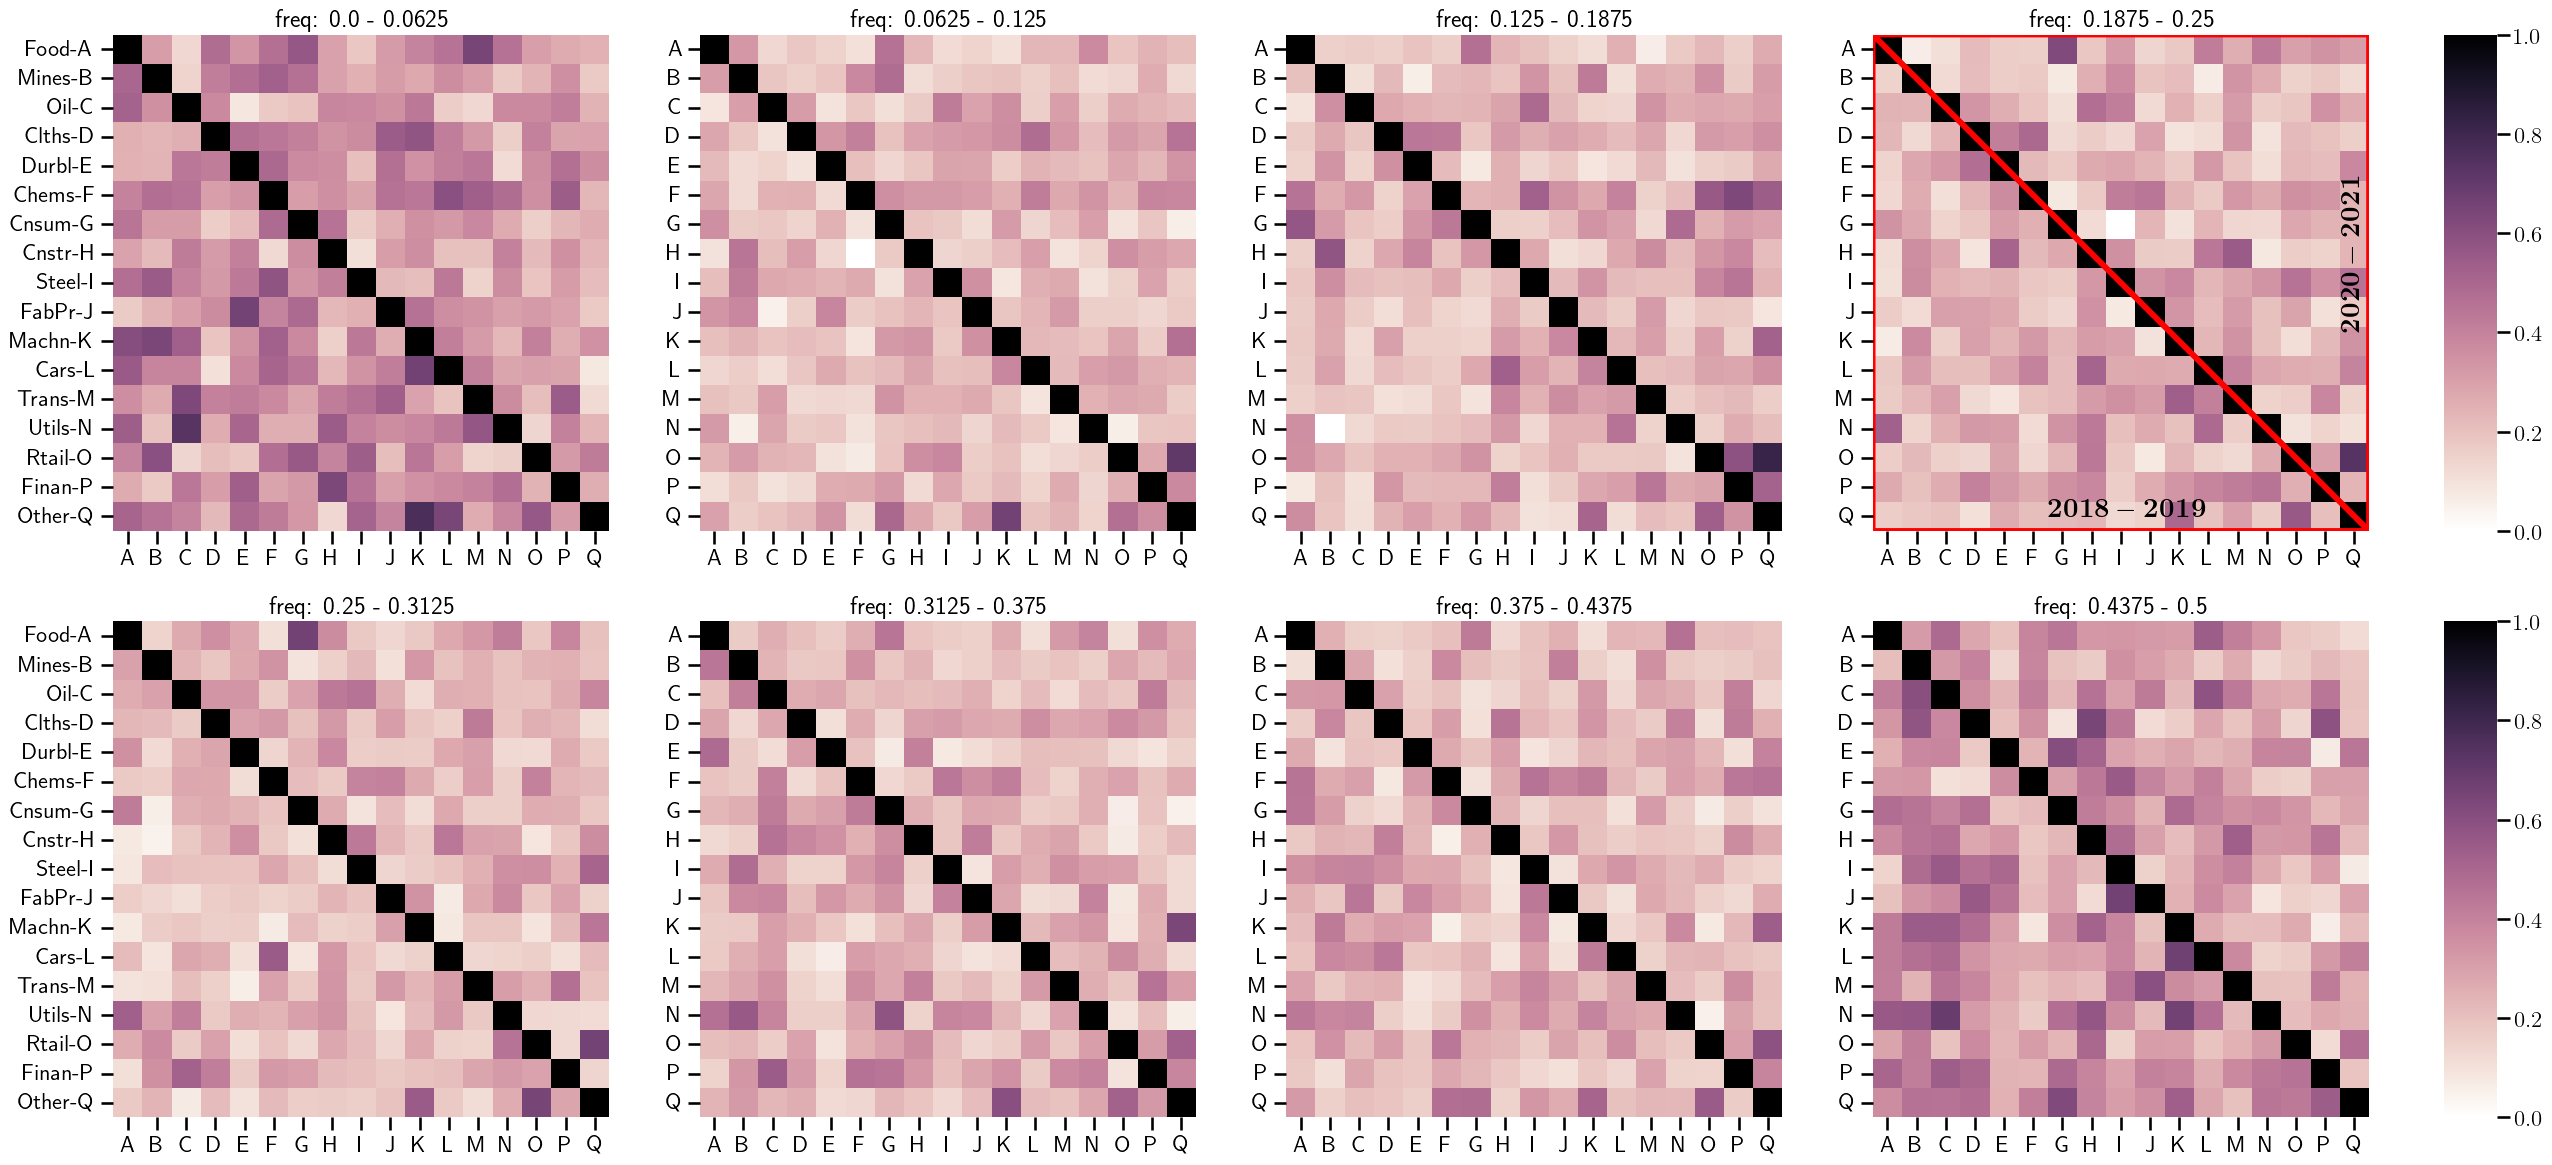

In [13]:
nrows=2
ncols=4
col_ = [rets_aft.columns[i].split(' ')[0]+'-'+alphabet[i] for i in range(len(rets_aft.columns))]
fig, ax = plt.subplots(nrows,ncols+1,figsize=(26,12), gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]}, sharex=False, sharey=False)

for k in range(Rl2_naive_aft.shape[-1]):
    if k%ncols==0:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_naive_bef[...,k].real>.05,Rl2_naive_bef[...,k].real,0)), index=col_, columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_naive_aft[...,k].real>.05,Rl2_naive_aft[...,k].real,0),k=1), index=col_, columns=alphabet[:len(rets_aft.columns)])
    else:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_naive_bef[...,k].real>.05,Rl2_naive_bef[...,k].real,0)), index=alphabet[:len(rets_bef.columns)], columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_naive_aft[...,k].real>.05,Rl2_naive_aft[...,k].real,0),k=1), index=alphabet[:len(rets_aft.columns)], columns=alphabet[:len(rets_aft.columns)])
    cbar_flag=True if k%ncols==ncols-1 else False
    sns.heatmap(bef_df+aft_df, cmap=pal, vmin=0, vmax=1, square=True,
                    cbar=cbar_flag, cbar_ax=ax[k//ncols, -1], ax=ax[k//ncols,k%ncols])
    if k%ncols!=0:
        ax[k//ncols,k%ncols].set_yticklabels(ax[k//ncols,k%ncols].get_yticklabels(),rotation=0)    
    ax[k//ncols,k%ncols].set_title(r"freq: %s - %s"%(K1[k],K1[k+1]))

path = Path([[0,0],[0,17],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[0,3].add_patch(patch)

path = Path([[0,0],[17,0],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[0,3].add_patch(patch)

ax[0,3].text(s=r'$\mathbf{2018-2019}$', y=16.5, x=6, fontsize=20)
ax[0,3].text(s=r'$\mathbf{2020-2021}$', y=10, x=16, fontsize=20, rotation=90)

plt.tight_layout()
plt.show()